## Estadística Aplicada

sesión 17 - 25 octubre

Joel Fayam Rivera Peña 2076323 Gpo 42

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
from statsmodels.tsa.arima.model import ARIMA

## pmdarima
import pmdarima as pm

In [3]:
## datos
desempleo_mex=pd.read_excel('desempleo_mex.xlsx')

In [5]:
desempleo_mex.dtypes

meses                 object
tasa de desempleo    float64
dtype: object

In [6]:
desempleo_mex.head()

,meses,tasa de desempleo
0,2005/01,3.951998
1,2005/02,3.773302
2,2005/03,3.627075
3,2005/04,3.363412
4,2005/05,3.303693


In [7]:
## Convertir en tiempo 
desempleo_mex['meses']=pd.to_datetime(desempleo_mex['meses'],format='%Y/%m')
## Hacerlo index
desempleo_mex=desempleo_mex.set_index('meses')
## Asignarle frecuencia
desempleo_mex=desempleo_mex.asfreq('MS')

In [8]:
desempleo_mex.index

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01'],
              dtype='datetime64[ns]', name='meses', length=224, freq='MS')

In [9]:
## missing values
desempleo_mex.isnull().sum()

tasa de desempleo    0
dtype: int64

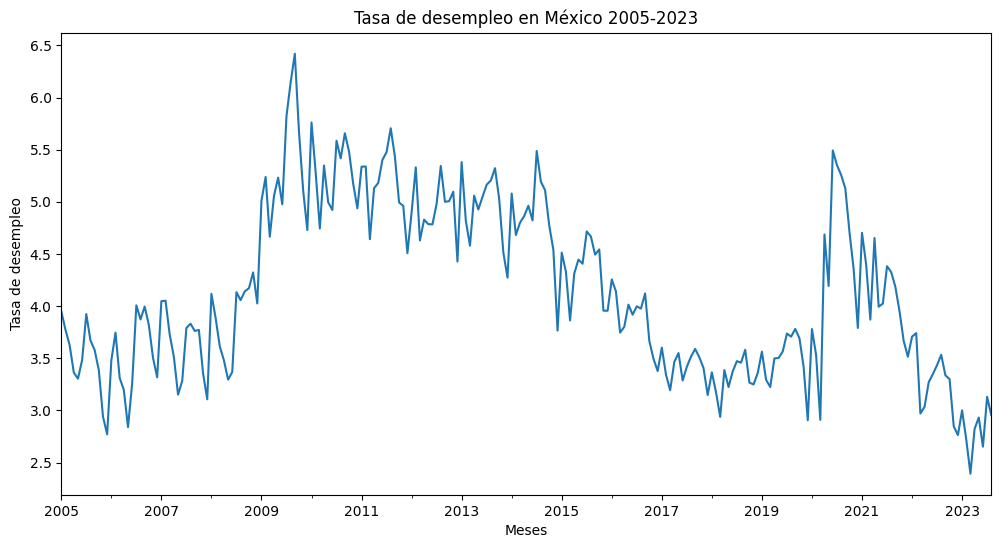

In [12]:
## Graficamos la serie de tiempo
desempleo_mex['tasa de desempleo'].plot(figsize=(12,6))
plt.title('Tasa de desempleo en México 2005-2023')
plt.xlabel('Meses')
plt.ylabel('Tasa de desempleo');

In [13]:
## Prueba de Dickey-Fuller aumentada
prueba_adf=adfuller(desempleo_mex['tasa de desempleo'])
pvalue=prueba_adf[1]
pvalue.round(2)

0.25

No rechazamos Ho, el desempleo es una serie no estacionaria

In [14]:
## Primeras diferencias
desempleo_mex['desempleo_diff']=desempleo_mex['tasa de desempleo'].diff()

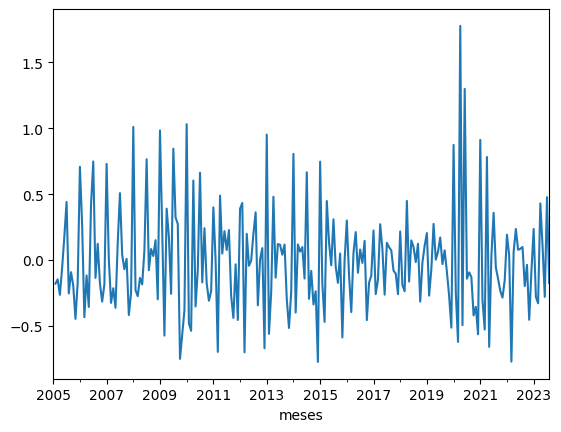

In [16]:
desempleo_mex['desempleo_diff'].plot();

In [17]:
## Comprobamos que las primeras diferencias sean estacionarias
prueba_adf1=adfuller(desempleo_mex['desempleo_diff'].dropna())
pvalue1=prueba_adf1[1]
pvalue1.round(2)

0.01

Rechazamos Ho, las primeras diferencias de desempleo son una serie estacionaria.

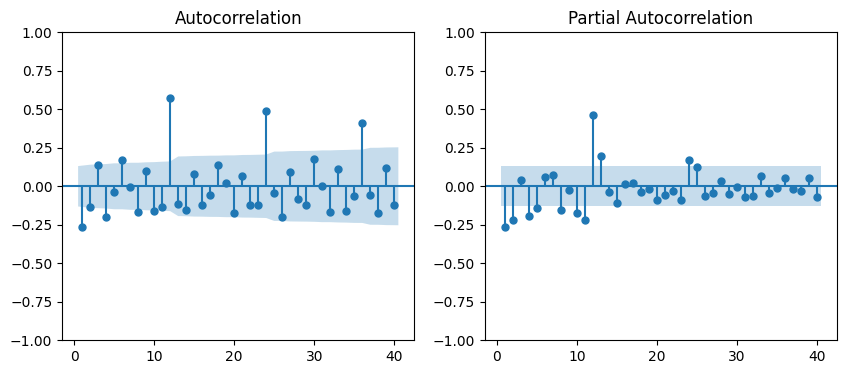

In [19]:
## Gráficas de correlación
ig, ax=plt.subplots(1,2,figsize=(10,4))
## 1er
plot_acf(desempleo_mex['desempleo_diff'].dropna(),zero=False,lags=40,ax=ax[0])
## 2da
plot_pacf(desempleo_mex['desempleo_diff'].dropna(),zero=False,lags=40,ax=ax[1])
plt.show()

Con las gráficas de correlación dado que emerge un patron que se repite, estamos ante una serie con componente estacionario, es decir, hay meses en los que el desempleo siempre sube o meses donde el desempleo siempre baja.

In [20]:
## Encontrar el orden del SARIMA
pm.auto_arima(desempleo_mex['tasa de desempleo'],
              start_p=1,start_q=1,
              max_p=7,max_q=7,
              ic='aic',
              seasonal=True,
              m=12,
              start_P=1,start_Q=1,
              max_P=7,max_Q=7,             
              )


ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

La tasa de desempleo es un SARIMA(1,1,0)(1,0,1,12)

In [21]:
## Modelo
model=ARIMA(desempleo_mex['tasa de desempleo'],
            order=(1,1,0),
            seasonal_order=(1,0,1,12))
results=model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  tasa de desempleo   No. Observations:                  224
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -28.306
Date:                            Wed, 25 Oct 2023   AIC                             64.613
Time:                                    15:51:29   BIC                             78.241
Sample:                                01-01-2005   HQIC                            70.115
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3689      0.061     -6.075      0.000      -0.488      -0.250
ar.S.L12       0.9763      0.014   

In [22]:
desempleo_mex['desempleo_arima']=results.predict()

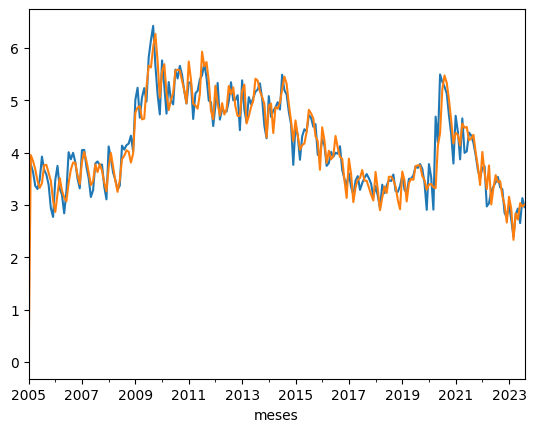

In [25]:
desempleo_mex['tasa de desempleo'].plot()
desempleo_mex['desempleo_arima'].plot();

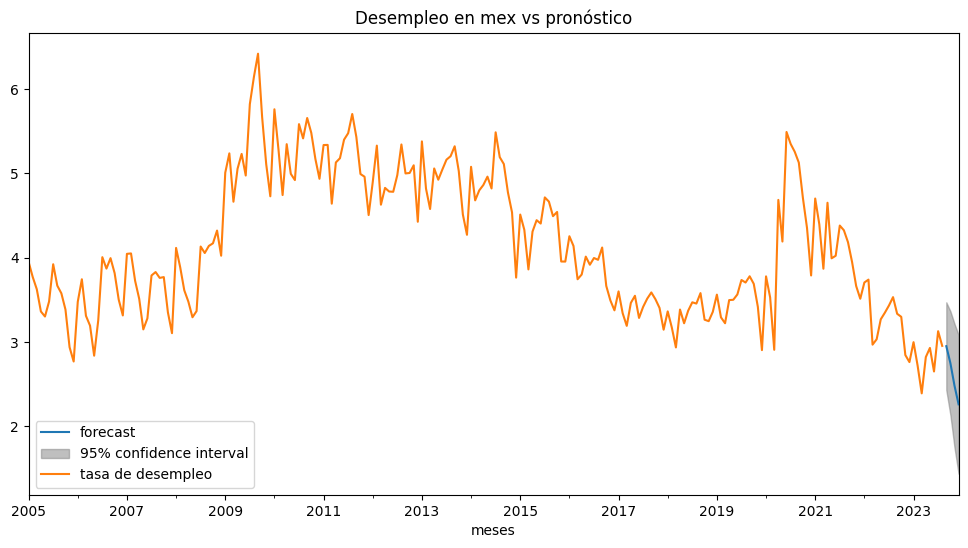

In [28]:
## Gráfica del pronóstico futuro
plot_predict(results,'2023-09-01','2023-12-01')
desempleo_mex['tasa de desempleo'].plot(figsize=(12,6))
plt.title('Desempleo en mex vs pronóstico')
plt.legend(loc='lower left')
plt.show()

## Pronóstico con los intervalos

In [29]:
forecast=results.get_forecast(steps=4)
forecast_mean=forecast.predicted_mean
forecast_ci=forecast.conf_int()

In [30]:
inicio='2023-09-01'
fin='2023-12-01'

In [31]:
pronostico_valor=forecast_mean[inicio:fin]
pronostico_intervalos=forecast_ci.loc[inicio:fin]

In [33]:
pro_desempleo=pd.DataFrame({'Pronóstico': pronostico_valor,
                            'Limite inferior': pronostico_intervalos.iloc[:,0],
                            'Limite superior': pronostico_intervalos.iloc[:,1]})

In [34]:
pro_desempleo

,Pronóstico,Limite inferior,Limite superior
2023-09-01,2.951735,2.431389,3.472082
2023-10-01,2.750669,2.135374,3.365963
2023-11-01,2.483561,1.750114,3.217009
2023-12-01,2.262441,1.439566,3.085317


In [37]:
print(f'Para septiembre pronosticamos una tasa de desempleo d: {pro_desempleo.iloc[0,0].round(2)}%\npero puede estar entre {pro_desempleo.iloc[0,1].round(2)}% y {pro_desempleo.iloc[0,2].round(2)}% con un 95% de confianza')

Para septiembre pronosticamos una tasa de desempleo d: 2.95%
pero puede estar entre 2.43% y 3.47% con un 95% de confianza
